In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../GlacierLakeDetectionICESat2/GlacierLakeIS2ML/')

from IS2ML_utils import *
from figscode import *

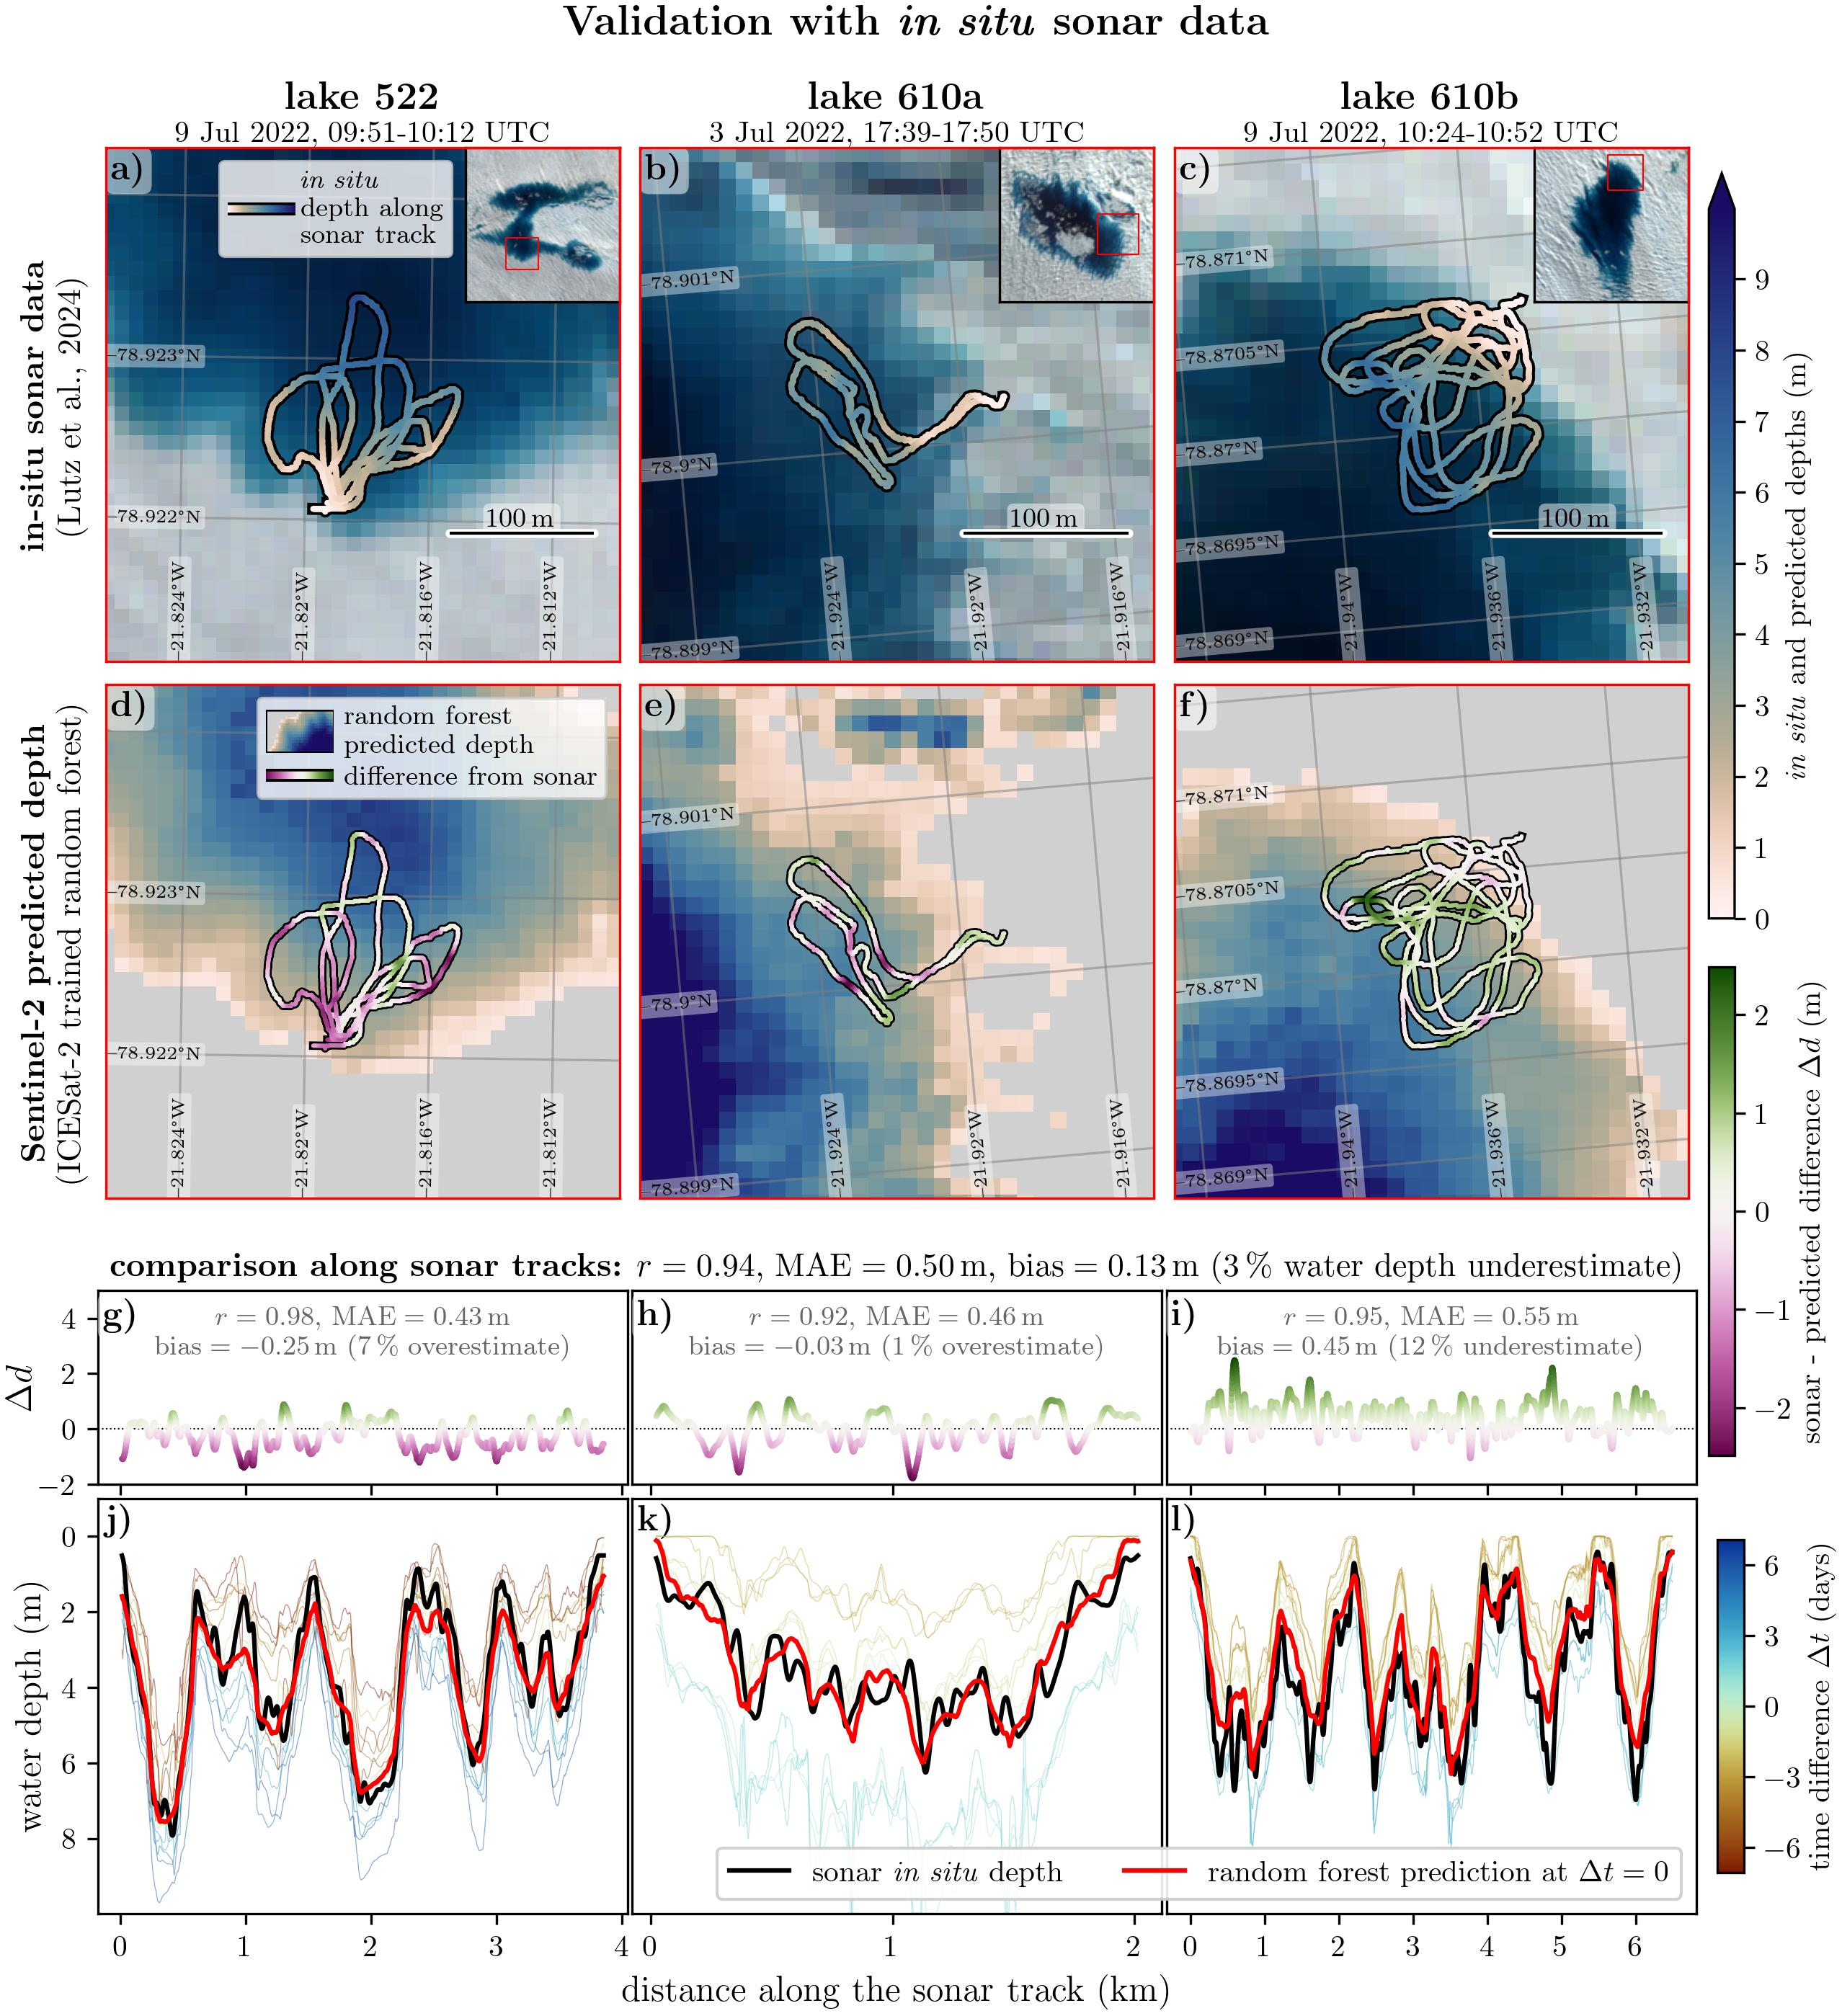

In [2]:
ids = ['Sonar_2022-07-09_lake522',
       'Sonar_2022-07-04_lake610a',
       'Sonar_2022-07-09_lake610b']

plt.rcParams.update({
    'font.size': 10,
    "text.usetex": True,
    "font.family": "Optima"
})

df_ensembl = pd.read_csv('data/sonar/along_track_validation_ensemble_mean_7d_predictions.csv')
df_result_valid = pd.read_csv('data/sonar/along_track_validation_individual_estimates.csv')

def ith_letter(i):
    return chr(97 + i)

plt.close('all')

from matplotlib.ticker import MaxNLocator
fig = plt.figure(figsize=[8.5,9.5], dpi=80)
gs = fig.add_gridspec(ncols=3, nrows=10)
axs = []
for i in range(2):
    for j in range(3):
        axs.append(fig.add_subplot(gs[i*3:(i+1)*3, j]))
for i in range(3):
    axs.append(fig.add_subplot(gs[6:, i]))

for ax in axs:
    for spine in ax.spines.values():
        spine.set_zorder(100)

vmin = 0
vmax = 9.99
cmap = cmc.lapaz_r
lw_col = 2

fs_side = matplotlib.rcParams['font.size']+1
fs_top = matplotlib.rcParams['font.size']+3

# graticule params
b_rems = [(1, 0), (2, 0), (2, 0)]
l_rems = [(0, 1), (0, 1), (0, 2)]
tbbx_grat = dict(facecolor='white', alpha=0.4, edgecolor='none', boxstyle="Round, pad=0.2")
grat_me_locs = ['bottom']
grat_pa_locs = ['left']
grat_mlines = 6
grat_fs = 6
grat_txtcol = 'black'
grat_gridcol = 'gray'
grat_gridls = '-'
grat_gridlw = 0.8
cbar_wid = 0.05
labsz = matplotlib.rcParams['font.size']+2
x_letter_pos = 0.01
y_letter_pos = [0.99, 0.99, 0.988, 0.96]
lettersize = matplotlib.rcParams['font.size']+2
bbox_letter = dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.15,rounding_size=0.25', lw=0, edgecolor='none')

for iid, id_sonar in enumerate(ids):
    
    img_fn_pred = 'data/sonar/validation_depth_estimates_' + id_sonar + '.tiff'
    img_fn_context = 'data/sonar/context_imagery/' + id_sonar + '_imagery_context.tiff'
    # print(img_fn_pred)
    img_dat = rio.open(img_fn_pred)
    crs_img = img_dat.crs

    tformat_in = '%Y-%m-%d %H:%M:%SZ'
    tformat_start = '%-d %b %Y, %H:%M'
    tformat_end = '%H:%M'
    gdf = gpd.read_file('data/sonar/lutz_2024/%s.shp' % id_sonar)
    gdf['timestamp'] = gdf.apply(lambda x: datetime.timestamp(datetime.strptime(x.Time, tformat_in).replace(tzinfo=timezone.utc)), axis=1)
    date_time_start = datetime.strftime(datetime.fromtimestamp(gdf.timestamp.min(), tz=timezone.utc), tformat_start)
    date_time_end = datetime.strftime(datetime.fromtimestamp(gdf.timestamp.max(), tz=timezone.utc), tformat_end)
    date_time_print = '%s-%s UTC' % (date_time_start, date_time_end)
    
    dfs = df_ensembl[df_ensembl.id_lake == ('lutz_' + id_sonar)].copy()
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(crs_img)
    gdfs[['x_img', 'y_img']] = gdfs.geometry.get_coordinates()

    fac_lims = 1.2
    xr = gdfs.x_img.max() - gdfs.x_img.min()
    yr = gdfs.y_img.max() - gdfs.y_img.min()
    rng = np.max((xr, yr))
    xc = (gdfs.x_img.min() + gdfs.x_img.max()) / 2
    yc = (gdfs.y_img.min() + gdfs.y_img.max()) / 2
    xl_img = (xc - fac_lims*rng, xc + fac_lims*rng)
    yl_img = (yc - fac_lims*rng, yc + fac_lims*rng)

    ###########################################################
    # SONAR DATA
    ax = axs[iid]
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in ax.spines.values():
        spine.set_color('red')
    rgb = img_dat.read([4,3,2])
    rgb = rgb / np.max(rgb)
    rioplot.show(rgb, ax=ax, transform=img_dat.transform)
    plot_colorline(x=gdfs.x_img, y=gdfs.y_img, c=gdfs.depth_smooth, cmap=cmap, ax=ax, lw=lw_col, vmin=vmin, vmax=vmax, zorder=11)
    # if iid == 2:
    #     cax = ax.inset_axes([1.04, 0.1, cbar_wid, 0.8])
    #     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.nanmin(data), vmax=vmax))
    #     sm._A = []
    #     cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='neither')
    #     cbar.set_label('sonar depth (m)')
    ax.plot(gdfs.x_img, gdfs.y_img, 'k-', lw=lw_col*2, zorder=10)
    ax.set_xlim(xl_img)
    ax.set_ylim(yl_img)
    add_graticule_crs(ax, crs=crs_img, meridians_locs=grat_me_locs, parallels_locs=grat_pa_locs, max_lines=grat_mlines, fontsz=grat_fs, 
                      color=grat_txtcol, addleft=r'--', addright=r'--', gridcol=grat_gridcol, gridls=grat_gridls, gridlw=grat_gridlw, 
                      inside=True, b_rem_me=b_rems[iid], l_rem_pa=l_rems[iid], tbbx=tbbx_grat)
    tit = id_sonar.split('_')[-1].replace('lake', 'lake ')
    ax.text(0.5, 1.06, '\\textbf{%s}' % tit, fontsize=fs_top, ha='center', va='bottom', transform=ax.transAxes)
    ax.text(0.5, 1.0, date_time_print, ha='center', va='bottom', transform=ax.transAxes)
    if iid == 0:
        ax.text(-0.1, 0.5, '\\textbf{in-situ sonar data}\n(Lutz et al., 2024)', rotation='vertical', transform=ax.transAxes, 
                ha='center', va='center', fontsize=fs_side)
    ax.text(x_letter_pos, y_letter_pos[0], '\\textbf{%s)}' % ith_letter(iid), ha='left', va='top', transform=ax.transAxes, fontsize=lettersize, bbox=bbox_letter)
    
    inset_size = 0.3
    ax_ins = ax.inset_axes([1-inset_size, 1-inset_size, inset_size, inset_size])
    ax_ins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in ax_ins.spines.values():
        spine.set_zorder(99)
    img_con = rio.open(img_fn_context)
    crs_cont = img_con.crs
    rioplot.show(img_con, ax=ax_ins)
    xl_con = ax.get_xlim()
    yl_con = ax.get_ylim()
    bbox_ins = np.array([[xl_con[i], yl_con[j]]  for i, j in [(0,0), (1,0), (1,1), (0,1), (0,0)]])
    polygon_ins = gpd.GeoSeries(Polygon([tuple(row) for row in bbox_ins]), crs=crs_img)
    polygon_ins.to_crs(crs_cont).boundary.plot(ax=ax_ins, lw=0.5, color='r', zorder=100)

    # legend
    if iid == 0:
        fn_art_depth = 'data/artists/depth_track.png'
        make_artist_image(fn_art_depth, cmap=cmap)
        handl_depth = ImageHandler()
        handl_depth.set_image(fn_art_depth, image_stretch=(0,-2))
        s1 = Line2D([], [])
        txt = '\\textit{in situ}\\vspace{-3ex}\ndepth along\\vspace{-3ex}\nsonar track'
        ax.legend([s1], [txt], handler_map={s1: handl_depth}, loc='upper right', handletextpad=0.2, 
                  borderpad=0.3, labelspacing=0.0, bbox_to_anchor=[1-inset_size, 1.0], fontsize=matplotlib.rcParams['font.size']-1, 
                  handlelength=2.5)

    ###########################################################
    # PREDICTED IMAGE
    p_start = 3
    ax = axs[iid + p_start]
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in ax.spines.values():
        spine.set_color('red')
    data = img_dat.read(1)
    ddiff = gdfs.depth_smooth - gdfs.depth_pred_mean
    # err_range = 2.75
    err_range = np.abs(ddiff).max()
    cmap_err = cmc.bam
    extend = 'max' if np.percentile(data, 98) > vmax else 'neither'
    imgp = rioplot.show(data, ax=ax, transform=img_dat.transform, cmap=cmap, vmin=vmin, vmax=vmax)
    data_ = data
    data_[data_ < gdfs.depth.min()] = 0.0
    data_[data_ > 0] = np.nan
    rioplot.show(data_, ax=ax, transform=img_dat.transform, cmap=cmc.grayC, vmin=-1, vmax=5)
    # if iid == 2:
    #     cax = ax.inset_axes([1.05, 0.1, cbar_wid, 0.8])
    #     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.nanmin(data), vmax=vmax))
    #     sm._A = []
    #     cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend=extend)
    #     cbar.set_label('predicted depth (m)')
        
    plot_colorline(x=gdfs.x_img, y=gdfs.y_img, c=ddiff, cmap=cmap_err, ax=ax, lw=lw_col-0.6, vmin=-err_range, vmax=err_range, zorder=11)
    # plot_colorline(x=gdfs.x_img, y=gdfs.y_img, c=gdfs.depth_smooth, cmap=cmap, ax=ax, lw=lw_col, vmin=vmin, vmax=vmax, zorder=11)
    # track_p = ax.plot(gdfs.x_img, gdfs.y_img, 'k-', lw=0.5, label='sonar track', zorder=12)
    track_p = ax.plot(gdfs.x_img, gdfs.y_img, 'k-', lw=(lw_col-0.6)*2, zorder=10)
    ax.set_xlim(xl_img)
    ax.set_ylim(yl_img)
    add_graticule_crs(ax, crs=crs_img, meridians_locs=grat_me_locs, parallels_locs=grat_pa_locs, max_lines=grat_mlines, fontsz=grat_fs, 
                      color=grat_txtcol, addleft=r'--', addright=r'--', gridcol=grat_gridcol, gridls=grat_gridls, gridlw=grat_gridlw, 
                      inside=True, b_rem_me=b_rems[iid], l_rem_pa=l_rems[iid], tbbx=tbbx_grat)
    if iid == 0:
        ax.text(-0.1, 0.5, '\\textbf{Sentinel-2 predicted depth}\n(ICESat-2 trained random forest)', rotation='vertical', transform=ax.transAxes, 
                ha='center', va='center', fontsize=fs_side)
    ax.text(x_letter_pos, y_letter_pos[1], '\\textbf{%s)}' % ith_letter(iid + p_start), ha='left', va='top', 
            transform=ax.transAxes, fontsize=lettersize, bbox=bbox_letter)
    
    # legend
    if iid == 0:
        fn_art_pred = 'data/artists/depth_pred.png'
        fn_art_diff = 'data/artists/diff_track.png'
        make_artist_image(fn_art_diff, cmap=cmap_err)
        with rio.open('data/sonar/validation_depth_estimates_Sonar_2022-07-09_lake522.tiff') as src:
            data = src.read(1)
        fig_art, ax_art = plt.subplots(figsize=[2,1])
        ax_art.imshow(data, cmap=cmap, vmin=0, vmax=6.5)
        data_ = data
        data_[data_ > 0] = np.nan
        ax_art.imshow(data_, cmap=cmc.grayC, vmin=-1, vmax=5)
        ax_art.set_xlim((4, 34))
        ax_art.set_ylim((18, 33))
        ax_art.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        for spine in ax_art.spines.values():
            spine.set_color('black')
            spine.set_linewidth(5)
            spine.set_zorder(100)
        fig_art.tight_layout(pad=0.2)
        fig_art.savefig(fn_art_pred, dpi=100, bbox_inches='tight', pad_inches=0.0, transparent=True)
        plt.close(fig_art)
        handl_diff = ImageHandler()
        handl_diff.set_image(fn_art_diff, image_stretch=(0,-2))
        handl_pred = ImageHandler()
        handl_pred.set_image(fn_art_pred, image_stretch=(0,8))
        s1, s2 = Line2D([], []), Line2D([], [])
        ax.legend([s1, s2], ['random forest\npredicted depth', 'difference from sonar'], handler_map={s1: handl_pred, s2: handl_diff}, labelspacing=0.3,
                 loc='upper right', handletextpad=0.4, borderpad=0.3, fontsize=matplotlib.rcParams['font.size']-1, handlelength=2.5)
    
    ###########################################################
    # ALONG-TRACK Differences and stats
    p_start = 6
    ax_bound = axs[iid + p_start]
    ax_bound.axis('off')
    ax = ax_bound.inset_axes([0.0, 0.62, 1.0, 0.28])
    plot_colorline(x=gdfs.xatc/1000, y=ddiff, c=ddiff, cmap=cmap_err, ax=ax, lw=lw_col, 
                   vmin=-err_range, vmax=err_range, zorder=11, autoscale=True)
    ax.axhline(0, color='k', lw=0.5, ls=':')
    ax.set_yticks([-2,0,2,4])
    ax.set_ylim((-2,5))
    if iid > 0: 
        ax.get_yaxis().set_visible(False)
    if iid == 0:
        ax.set_ylabel('$\\Delta d$', labelpad=0.1, fontsize=labsz)
    ax.tick_params(labelbottom=False)

    mae_ = np.mean(np.abs(ddiff))
    bias_ = np.mean(ddiff)
    r_pearson_ = pearsonr(gdfs.depth_pred_mean, gdfs.depth_smooth).statistic
    perc_ = np.sum(ddiff) / np.sum(gdfs.depth_smooth) * 100
    over_under_ = 'overestimate' if perc_ < 0 else 'underestimate'
    txt = '$r = %.2f$, $\\mathrm{MAE}=%.2f\\mathrm{\\,m}$\n' % (r_pearson_, mae_)
    txt += '$\\mathrm{bias} = %.2f\mathrm{\\,m}$ ($%.0f\\mathrm{\\,\\%%}$ %s)' % (bias_, np.abs(perc_), over_under_)
    ax.text(0.5, 0.78, txt, ha='center', va='center', transform=ax.transAxes, fontsize=9, color=[0.4]*3)
    ax.text(x_letter_pos, y_letter_pos[3], '\\textbf{%s)}' % ith_letter(iid + p_start), ha='left', va='top', transform=ax.transAxes, fontsize=lettersize, bbox=bbox_letter)

    ###########################################################
    # ALONG-TRACK COMPARISON
    p_start = 9
    ax = ax_bound.inset_axes([0.0, 0.0, 1.0, 0.6], sharex=ax)
    for spine in ax.spines.values():
        spine.set_zorder(100)
    p_sonar, = ax.plot(gdfs.xatc/1000, gdfs.depth_smooth, 'k-', label='sonar \\textit{in situ} depth', zorder=11)
    p_pred, = ax.plot(gdfs.xatc/1000, gdfs.depth_pred_mean, 'r-', label=r'random forest prediction at $\Delta t=0$', zorder=11)

    cmap_tdiff = cmc.roma
    vmx = np.nanmax(np.abs(df_result_valid.tdiff_sec))
    df_lake = df_result_valid[df_result_valid.id_lake == ('lutz_'+id_sonar)]
    for iimg, thisid in enumerate(df_lake.IS2_id.unique()):
        df_f = df_lake[df_lake.IS2_id == thisid]
        thiscol = cmap_tdiff((df_f.tdiff_sec.mean() + vmx) / (2*vmx))
        ax.plot(df_f.xatc/1000, df_f.depth_pred, color=thiscol, alpha=0.5, lw=0.3, zorder=10)
    
    ax.set_ylim((10, -1))
    ax.set_yticks([0,2,4,6,8])
    if iid == 0:
        ax.set_ylabel('water depth (m)', fontsize=labsz)
    else:
        ax.get_yaxis().set_visible(False)
    if iid == 1:
        ax.set_xlabel('distance along the sonar track (km)', fontsize=labsz)
    # ax.get_xaxis().set_visible(False)
    if iid == 2:
        cax = ax.inset_axes([1.04, 0.1, cbar_wid, 0.8])
        sm = plt.cm.ScalarMappable(cmap=cmap_tdiff, norm=plt.Normalize(vmin=-vmx/3600/24, vmax=vmx/3600/24))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='neither')
        cbar.set_label(r'time difference $\Delta t$ (days)', labelpad=1)
        cax.yaxis.set_major_locator(MaxNLocator(integer=True))
        cax.set_yticks([-6, -3, 0, 3, 6])
    ax.text(x_letter_pos, y_letter_pos[2], '\\textbf{%s)}' % ith_letter(iid + p_start), ha='left', va='top', transform=ax.transAxes, fontsize=lettersize, bbox=bbox_letter)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
ddiff = df_ensembl.depth_smooth - df_ensembl.depth_pred_mean
mae = np.mean(np.abs(ddiff))
bias = np.mean(ddiff)
perc = np.sum(ddiff) / np.sum(df_ensembl.depth_smooth) * 100
r_pearson = pearsonr(df_ensembl.depth_pred_mean, df_ensembl.depth_smooth).statistic
over_under = 'overestimate' if perc < 0 else 'underestimate'
txt = '\\textbf{Validation with \\textit{in situ} sonar data}\n\n'
fig.suptitle(txt, fontsize=matplotlib.rcParams['font.size']+4)
    
fig.tight_layout(pad=0.3, h_pad=0.3, w_pad=0.0)

ax_capt = axs[7].inset_axes([-1.0, 0.9, 3.0, 0.1])
ax_capt.axis('off')
txt = '\\textbf{comparison along sonar tracks:} $r = %.2f$, $\\mathrm{MAE}=%.2f\\mathrm{\\,m}$, ' % (r_pearson, mae)
txt += '$\\mathrm{bias} = %.2f\mathrm{\\,m}$ ($%.0f\\mathrm{\\,\\%%}$ water depth %s)' % (bias, np.abs(perc), over_under)
ax_capt.text(0.5, 0.1, txt, ha='center', va='bottom', fontsize=labsz-1)

ax = axs[2]
cax = ax.inset_axes([1.04, -0.5, cbar_wid, 1.45])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.nanmin(data), vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='max')
cbar.set_label('\\textit{in situ} and predicted depths (m)')
cax.set_yticks(list(range(10)))

ax = axs[5]
cax = ax.inset_axes([1.04, -0.5, cbar_wid, 0.95])
sm = plt.cm.ScalarMappable(cmap=cmap_err, norm=plt.Normalize(vmin=-err_range, vmax=err_range))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='neither')
cbar.set_label('sonar - predicted difference $\\Delta d$ (m)', labelpad=1)

axleg = axs[8].inset_axes([-2.0, 0.0, 3.0, 1.0])
axleg.axis('off')
axleg.legend(handles=[p_sonar, p_pred], loc='lower right', ncols=2, fontsize=10, framealpha=0.9);

# scalebars
scalebar_length = 100 # meters
scalebar_y = 0.25
scalebar_x_right = 0.95
for ax in axs[:3]:
    axxl = ax.get_xlim()
    xxtent = axxl[1] - axxl[0]
    xlen = scalebar_length / xxtent
    x_start = scalebar_x_right - xlen
    line_border = plt.Line2D([x_start, scalebar_x_right], [scalebar_y]*2, transform=ax.transAxes, color='w', lw=3, solid_capstyle='round', zorder=20)
    ax.add_line(line_border)
    line_middle = plt.Line2D([x_start, scalebar_x_right], [scalebar_y]*2, transform=ax.transAxes, color='k', lw=1, solid_capstyle='butt', zorder=21)
    ax.add_line(line_middle)
    xmid = (x_start+scalebar_x_right)/2
    ax.text(xmid, scalebar_y+0.003, '\\textbf{$%.0f\\mathrm{\\,m}$}'%scalebar_length, ha='center', va='bottom', bbox=bbox_letter, transform=ax.transAxes,
           fontsize=matplotlib.rcParams['font.size']-1, zorder=19)

figfn = 'figures/fig03_validation-sonar.jpg'
for savefn in [figfn, figfn.replace('.jpg', '.pdf')]:
    fig.savefig(savefn, dpi=300, bbox_inches='tight', pad_inches=0.03)
fig.savefig(figfn.replace('.jpg','_lowres.jpg'), dpi=100, bbox_inches='tight', pad_inches=0.03)
plt.close(fig)
display(Image(figfn))

## Hacky way for cropping context geotiffs

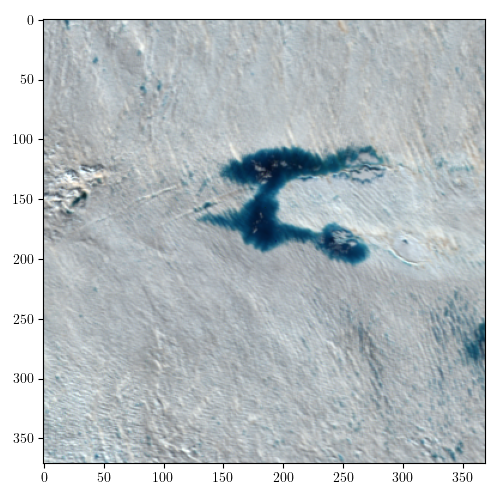

In [3]:
import rasterio
from rasterio.windows import from_bounds

#### Define the path to your input and output GeoTIFF files
input_tiff = 'data/sonar/context_imagery/Sonar_2022-07-09_lake522_imagery_context_10.tiff'
# input_tiff = 'data/sonar/context_imagery/Sonar_2022-07-04_lake610a_imagery_context_10.tiff'
# input_tiff = 'data/sonar/context_imagery/Sonar_2022-07-09_lake610b_imagery_context_10.tiff'

with rio.open(input_tiff) as src:
    r = src.read(1)  # Red channel
    g = src.read(2)  # Green channel
    b = src.read(3)  # Blue channel
    
    # Stack the bands into a single 3D array (height, width, 3)
    rgb_image = np.dstack((r, g, b))

fig, ax = plt.subplots(figsize=[5,5])
ax.imshow(rgb_image)
fig.tight_layout()

In [4]:
xl = ax.get_xlim()
yl = ax.get_ylim()
print('size_pxls = %.0f' % (xl[1] - xl[0]))
print('xoff = %.0f' % xl[0])
print('yoff = %.0f' % yl[1])

size_pxls = 369
xoff = -0
yoff = -0


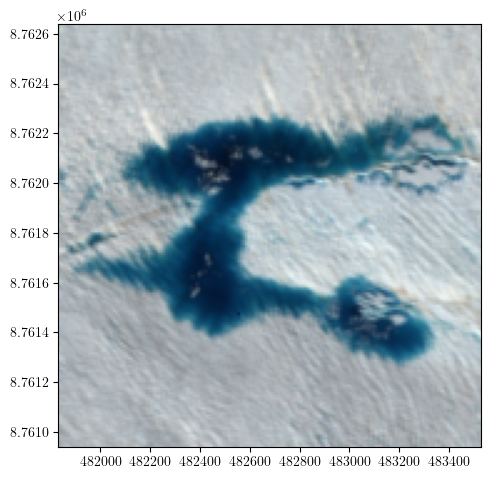

In [5]:
if 'Sonar_2022-07-09_lake522' in input_tiff:
    size_pxls = 170
    xoff = 122
    yoff = 69
if 'Sonar_2022-07-04_lake610a' in input_tiff:
    size_pxls = 117
    xoff = 68
    yoff = 93
if 'Sonar_2022-07-09_lake610b' in input_tiff:
    size_pxls = 131
    xoff = 79
    yoff = 136

from rasterio.windows import Window
output_tiff = input_tiff.replace('_10.tiff', '.tiff')
window = Window(col_off=xoff, row_off=yoff, width=size_pxls, height=size_pxls)

# Open the input GeoTIFF
with rio.open(input_tiff) as src:
    
    # Crop the data using the window
    cropped_data = src.read(window=window)
    
    # Update the transform to reflect the crop
    transform = src.window_transform(window)
    
    # Write the cropped data to a new GeoTIFF
    with rasterio.open(
        output_tiff,
        'w',
        driver='GTiff',
        height=cropped_data.shape[1],
        width=cropped_data.shape[2],
        count=src.count,
        dtype=cropped_data.dtype,
        crs=src.crs,
        transform=transform,
    ) as dst:
        dst.write(cropped_data)

fig, ax = plt.subplots(figsize=[5,5])
with rio.open(output_tiff) as src:
    rioplot.show(src, ax=ax)
fig.tight_layout()
display(fig)
plt.close(fig)